In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

## TRank Data

The TRank data is pulled the day before the first play in game.

https://barttorvik.com/timemachine/team_results/20150316_team_results.json.gz
https://barttorvik.com/timemachine/team_results/20160314_team_results.json.gz
https://barttorvik.com/timemachine/team_results/20170313_team_results.json.gz
https://barttorvik.com/timemachine/team_results/20180312_team_results.json.gz
https://barttorvik.com/timemachine/team_results/20190318_team_results.json.gz
https://barttorvik.com/timemachine/team_results/20210317_team_results.json.gz

## Game data
The actual games played were pulled using the game finder on https://barttorvik.com/ filtering for tournament games. 


In [2]:
# Trank 
TrankList = ['20150316_team_results.json','20160314_team_results.json',\
             '20170313_team_results.json','20180312_team_results.json','20190318_team_results.json',\
             '20210317_team_results.json']

tourneyGames = ['NCAA2015.csv','NCAA2016.csv',\
               'NCAA2017.csv','NCAA2018.csv','NCAA2019.csv','NCAA2021.csv']

Year = [2015,2016,2017,2018,2019,2021]

In [3]:
from sportsipy.ncaab.schedule import Schedule
from datetime import datetime
from dateutil import parser
from tqdm import tqdm


def WriteSortedGames(FileList,YearList):

    # This file has the coversions between bart torvick and sports reference
    Translator = pd.read_csv(os.path.join('DATA','Translator.csv'),header=None)


    for ind,(games_file,year) in enumerate(zip(FileList,YearList)):

        print(f' Processing {year}')

        # Empty dataframe with our columns
        df = pd.DataFrame(columns = ['Datetime' , 'Winner', 'Loser'])

        # Read the raw game data
        Games = pd.read_csv(os.path.join('DATA',games_file),header=None)

        # Loop through all relevent games
        for indexs, game in tqdm(Games[4:].iterrows(),total=63): # games 0-3 playin games


            winner= game[1]      
            loser = game[2]

            # Translate team to sports ref
            winner_trans = Translator[Translator[1].str.fullmatch(winner)]        
            winner_ref = winner_trans.iloc[0][0]

            # Convert date to datetime
            datetime_object = datetime.strptime(game[0],  '%m/%d/%Y')

            # Grab schedule data that includes tip times
            schedule = Schedule(winner_ref,year=year)


            matched = False
            for gameref in schedule:
                if gameref.type =='NCAA' and datetime_object==parser.parse(gameref.date):
                    matched= True
                    t = [parser.parse(game[0]+' '+gameref.time),winner,loser]
                    df.loc[len(df)] = t  

            if not matched:
                print(f'{game[0]} , Winner - {winner}, Loser - {loser} - No match??')

        # After all games are added sort by datetime
        df = df.sort_values(by='Datetime', ascending=True)

        # Write to file
        df.to_csv(os.path.join('DATA',f'GamesSorted_{year}.csv'),index=False)
        
    return



# Check if we have sorted the games by datetime, if not do it
gameListSorted = []
for year in Year:
    if os.path.isfile(os.path.join('DATA',f'GamesSorted_{year}.csv')):
        gameListSorted.append(f'GamesSorted_{year}.csv')
    else:
        WriteSortedGames(tourneyGames,Year)
        gameListSorted.append(f'GamesSorted_{year}.csv')


 Processing 2015


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  2.01it/s]


 Processing 2016


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:33<00:00,  1.91it/s]


 Processing 2017


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:36<00:00,  1.71it/s]


 Processing 2018


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.94it/s]


 Processing 2019


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:30<00:00,  2.04it/s]


 Processing 2021


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:30<00:00,  2.05it/s]


In [4]:
gameOdds = np.zeros((10,64))
coinFlip = np.zeros((64))
gameOdds[:,0] = 1
coinFlip[0] = 1

for ind,(trank_file,games_file,year) in enumerate(zip(TrankList,gameListSorted,Year)):
    print(f' Processing {year}')
    
    TRank = pd.read_json(os.path.join('DATA',trank_file), lines=False)
    Games = pd.read_csv(os.path.join('DATA',games_file))

    for indexs, game in Games.iterrows(): # games 0-3 playin games

        # Get the winner's EM
        winnerEff = TRank[8].loc[TRank[1] == game[1]]
        winnerEff = winnerEff.iat[0]
        
        # Get the loser's EM
        loserEff = TRank[8].loc[TRank[1] == game[2]]
        loserEff = loserEff.iat[0]

        # log5 results
        oddsOfOutcome = (winnerEff-winnerEff*loserEff)/(winnerEff+loserEff-2*winnerEff*loserEff) 

        # add to array
        gameOdds[ind,indexs+1] = oddsOfOutcome
          
        if ind == 0:
            coinFlip[indexs+1] = 0.5 

totalOdds = np.cumprod(gameOdds,1)
coinFlipOdds = np.cumprod(coinFlip)

 Processing 2015
 Processing 2016
 Processing 2017
 Processing 2018
 Processing 2019
 Processing 2021


C:\Users\Kevin Porter\anaconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator


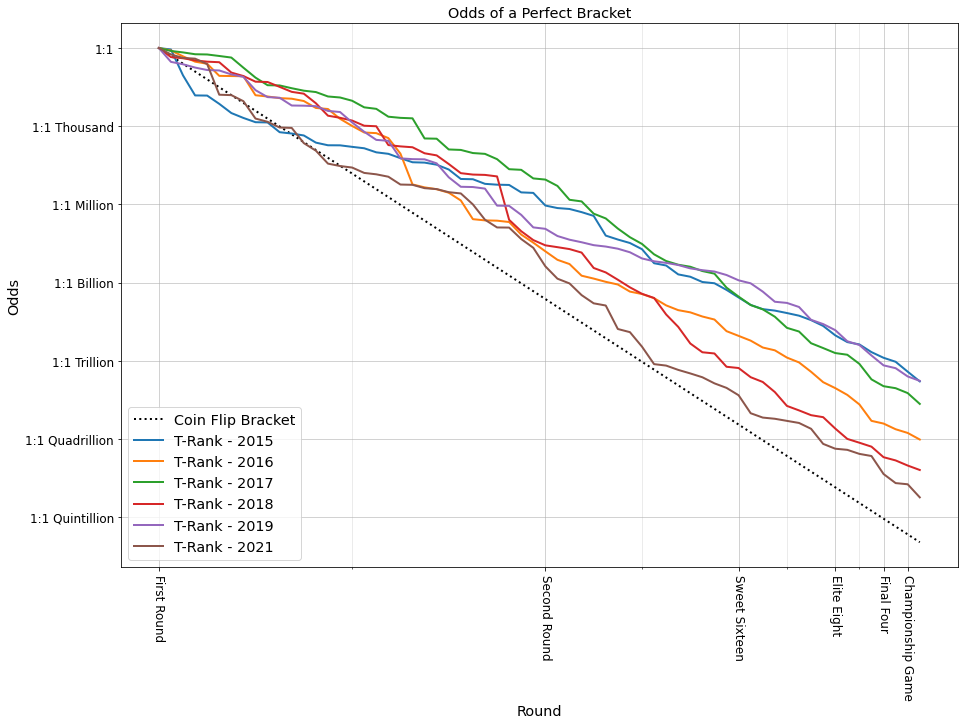

In [5]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15,10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)


fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)

line, = ax.plot(coinFlipOdds, color='black', lw=2,linestyle='dotted',label='Coin Flip Bracket')

for ind,year in enumerate(Year):
    ax.plot(totalOdds[ind,:],  lw=2,label=f'T-Rank - {year}')

ax.set_yscale('log', base=10)
plt.legend(loc='lower left')
plt.xlabel('Round')
plt.ylabel('Odds')
plt.title('Odds of a Perfect Bracket')


ax.set_yticks([10**0,10**-3,10**-6,10**-9,10**-12,10**-15,10**-18])
ax.set_yticklabels(['1:1','1:1 Thousand','1:1 Million','1:1 Billion','1:1 Trillion','1:1 Quadrillion','1:1 Quintillion'])


ax.set_xticklabels(ax.get_xticks(), rotation = -90)
ax.set_xticks([0,32,48,56,60,62])
ax.set_xticks([16,40,52,58], minor = True)
ax.set_xticklabels(['First Round','Second Round','Sweet Sixteen','Elite Eight','Final Four','Championship Game'])

ax.grid(which = 'minor', alpha = 0.3)
ax.grid(which = 'major', alpha = 0.7)


plt.show()